In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Define path to dataset directory
import os
project_path = 'E:/project'
dataset_folder = 'dermoscopy'
dataset_path = os.path.join(project_path, dataset_folder)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(-40, 40)),
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Load the dataset
from torchvision.datasets import ImageFolder
combined_dataset = ImageFolder(root=dataset_path, transform=data_transforms['train'])
# Split the dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


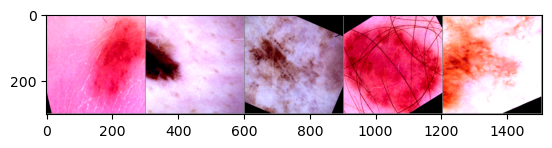

Labels: tensor([0, 1, 1, 1, 1])
torch.Size([5, 3, 299, 299])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms, utils
inputs, labels = next(iter(train_loader))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(utils.make_grid(inputs))
print('Labels:', labels)
for images, labels in train_loader:
    print(images.size())
    break

In [6]:
import os
normal_folder = os.path.join(dataset_path, 'HAM10000_images_part_1')
pneumonia_folder = os.path.join(dataset_path, 'HAM10000_images_part_1')
print("Benign Samples:", len(os.listdir(normal_folder)))
print("Malignant Samples:", len(os.listdir(pneumonia_folder)))

Benign Samples: 5000
Malignant Samples: 5000


In [7]:
for batch, labels in train_loader:
    print("Batch Shape:", batch.shape)
    print("Labels:", labels)
    break

Batch Shape: torch.Size([5, 3, 299, 299])
Labels: tensor([0, 1, 1, 0, 1])


In [ ]:
import torch.nn as nn
class ChestXRayEncoder(nn.Module):
    def __init__(self):
        super(ChestXRayEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, weight, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

encoder = ChestXRayEncoder()
weight = torch.randn(256)
for batch, labels in train_loader:
    features = encoder(weight, batch)
    print("Encoded Features Shape:", features.shape)
    break

In [ ]:
#Define AACoder
import torch
import torch.nn as nn
import torch.nn.functional as F
class AACoder(nn.Module):
    def __init__(self, input_size, noise_size, output_size):
        super(AACoder, self).__init__()
        self.fc1 = nn.Linear(input_size + noise_size, output_size)
        self.fc2 = nn.Linear(output_size, input_size)
    def forward(self, original_features, gaussian_noise, weight):
        combined_features = torch.cat((original_features, gaussian_noise), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x
input_size = features.size(1) 
noise_size = 100  
output_size = 256  
aacoder = AACoder(input_size, noise_size, output_size)
gaussian_noise = torch.randn(features.size(0), noise_size)
aacoder_weight = torch.randn(output_size)
attack_features = aacoder(features, gaussian_noise, aacoder_weight)
print("Attack Features Shape:", attack_features.shape)

In [ ]:
#Define Decoder
import torch
import torch.nn as nn
class ReconstructionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReconstructionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # Adjust input_size here

    def forward(self, input_features):
        return self.fc(input_features)
class AttentionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(AttentionBlock, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, classification_features):
        attention_features = self.sigmoid(self.fc(classification_features))
        return attention_features
class CombineBlock(nn.Module):
    def __init__(self):
        super(CombineBlock, self).__init__()

    def forward(self, perturbation_restoration, attention_features):
        final_perturbation = perturbation_restoration * attention_features
        return final_perturbation
class Decoder(nn.Module):
    def __init__(self, reconstruction_input_size, attention_input_size, perturbation_restoration_output_size):
        super(Decoder, self).__init__()
        self.reconstruction_block = ReconstructionBlock(reconstruction_input_size, perturbation_restoration_output_size)
        self.attention_block = AttentionBlock(attention_input_size, perturbation_restoration_output_size)
        self.combine_block = CombineBlock()
    def forward(self, classification_features, attack_features):
        attention_features = self.attention_block(classification_features)
        perturbation_restoration = self.reconstruction_block(attack_features)
        final_perturbation = self.combine_block(perturbation_restoration, attention_features)
        return final_perturbation
chest_xray_encoder_output_size = 256
aacoder_output_size = 256
decoder_output_size = 1280
reconstruction_input_size = aacoder_output_size  
attention_input_size = chest_xray_encoder_output_size  
perturbation_restoration_output_size = decoder_output_size  
decoder = Decoder(reconstruction_input_size, attention_input_size, perturbation_restoration_output_size)
classification_features = torch.randn(5, attention_input_size)  
attack_features = torch.randn(5, reconstruction_input_size)     
final_perturbation = decoder(classification_features, attack_features)
print("Final Perturbation Shape:", final_perturbation.shape)

In [ ]:
#Define Discriminator
import torch
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x / torch.max(torch.abs(x))  
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
def wasserstein_distance(features1, features2):
    w_distance = torch.mean(features1 - features2)
    return w_distance

In [ ]:
# Define a function to visualize images
def visualize_samples(original, perturbed, adversarial):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Original Image', 'Perturbed Image', 'Adversarial Sample']
    samples = [original, perturbed, adversarial]
    for ax, title, sample in zip(axes, titles, samples):
        ax.imshow(np.transpose(sample.detach().numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')
    plt.show()
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    for i in range(len(batch)):
        visualize_samples(batch[i], restored_perturbations_reshaped[i], adversarial_samples[i])
    break

In [ ]:
resnet50 = models.resnet50(weights=True)
densenet121 = models.densenet121(weights=True)
vgg16 = models.vgg16(weights=True)
resnet50 = models.resnet50(weights=True)
densenet121 = models.densenet121(weights=True)
vgg16 = models.vgg16(weights=True)

In [ ]:
import torch
import torch.nn.functional as F
alpha = 1.0
beta = 1.0
gamma = 1.0
c = 0.1 
def calculate_adversarial_classification_loss(outputs, labels):
    return F.cross_entropy(outputs, labels)
def calculate_adversarial_generation_loss(discriminator_outputs):
    return torch.mean(1 - discriminator_outputs)
def calculate_perturbation_magnitude_loss(perturbation):
    return torch.mean(torch.max(torch.tensor(0.0), torch.norm(perturbation, p=2) - c))
def calculate_feature_consistency_loss(features_original, features_perturbed):
    return F.mse_loss(features_original, features_perturbed)
for batch, labels in train_loader:
    original_features = encoder(weight, batch)
    gaussian_noise = torch.randn(original_features.size(0), noise_size)
    attack_features = aacoder(original_features, gaussian_noise, aacoder_weight)
    restored_perturbations = decoder(original_features, attack_features)
    restored_perturbations_reshaped = restored_perturbations.view(restored_perturbations.size(0), -1, 1, 1)
    num_channels_original = batch.size(1)
    num_channels_perturbations = restored_perturbations_reshaped.size(1)
    if num_channels_original != num_channels_perturbations:
        restored_perturbations_reshaped = restored_perturbations_reshaped[:, :num_channels_original, :, :]
    adversarial_samples = batch + restored_perturbations_reshaped
    resnet_outputs = resnet50(adversarial_samples)
    densenet_outputs = densenet121(adversarial_samples)
    vgg16_outputs = vgg16(adversarial_samples)
    loss_resnet = calculate_adversarial_classification_loss(resnet_outputs, labels)
    loss_densenet = calculate_adversarial_classification_loss(densenet_outputs, labels)
    loss_vgg16 = calculate_adversarial_classification_loss(vgg16_outputs, labels)
    print("Adversarial Classification Loss (ResNet-50):", loss_resnet.item())
    print("Adversarial Classification Loss (DenseNet-121):", loss_densenet.item())
    print("Adversarial Classification Loss (VGG-16):", loss_vgg16.item())
    break

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def calculate_l2_norm(original_images, adversarial_samples):
    l2_norms = []
    for original_image, adversarial_sample in zip(original_images, adversarial_samples):
        perturbation = adversarial_sample - original_image
        l2_norm = np.linalg.norm(perturbation)
        l2_norms.append(l2_norm)
    return l2_norms
for batch, labels in train_loader:
    resnet_outputs = resnet50(batch)
    densenet_outputs = densenet121(batch)
    vgg16_outputs = vgg16(batch)
    resnet_preds = torch.argmax(resnet_outputs, dim=1).cpu().numpy()
    densenet_preds = torch.argmax(densenet_outputs, dim=1).cpu().numpy()
    vgg16_preds = torch.argmax(vgg16_outputs, dim=1).cpu().numpy()
    accuracy_resnet = accuracy_score(labels.cpu().numpy(), resnet_preds)
    accuracy_densenet = accuracy_score(labels.cpu().numpy(), densenet_preds)
    accuracy_vgg16 = accuracy_score(labels.cpu().numpy(), vgg16_preds)
    auc_resnet = roc_auc_score(labels.cpu().numpy(), resnet_outputs[:, 1].detach().cpu().numpy())
    auc_densenet = roc_auc_score(labels.cpu().numpy(), densenet_outputs[:, 1].detach().cpu().numpy())
    auc_vgg16 = roc_auc_score(labels.cpu().numpy(), vgg16_outputs[:, 1].detach().cpu().numpy())
    l2_norm_resnet = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    l2_norm_densenet = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    l2_norm_vgg16 = calculate_l2_norm(batch.detach().cpu().numpy(), adversarial_samples.detach().cpu().numpy())
    print("Accuracy (ResNet-50, DenseNet-121, VGG-16):", accuracy_resnet, accuracy_densenet, accuracy_vgg16)
    print("AUC (ResNet-50, DenseNet-121, VGG-16):", auc_resnet, auc_densenet, auc_vgg16)
    print("L2 Norm (ResNet-50):", l2_norm_resnet)
    print("L2 Norm (DenseNet-121):", l2_norm_densenet)
    print("L2 Norm (VGG-16):", l2_norm_vgg16)
    break

In [ ]:
import matplotlib.pyplot as plt
models = ['ResNet-50', 'DenseNet-121', 'VGG-16']
accuracies = [accuracy_resnet, accuracy_densenet, accuracy_vgg16]
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.grid(True)
plt.show()